### Table of Contents

* [1. Load libraries and data](#chapter1)
* [2. Illustrated selected data](#chapter2)
* [3. Fit the Lee-Carter model to one population](#chapter3)
* [4. Define the different networks considered](#chapter4)
* [5. Prepare data for RNNs](#chapter5)
* [6. Toy Examples Recurrent Neural Nets](#chapter6)
* [7. Fit recurrent neural network to HMD data for female and male individually](#chapter7)
* [8. Fit recurrent neural network to HMD data for both genders](#chapter8)

### Paper

Analysis made based on paper: <br>
* Title: "Lee and Carter go Machine Learning: Recurrent Neural Networks"
* Authors: Richman, Ronald and Wuthrich, Mario V.
* Date: August 22, 2019
* Abstract: https://ssrn.com/abstract=3441030

Notebook is based on the original code in R written by Ronald Richman and Mario Wuthrich: <br>
https://github.com/JSchelldorfer/ActuarialDataScience/tree/master/6%20-%20Lee%20and%20Carter%20go%20Machine%20Learning%20Recurrent%20Neural%20Networks

### 1. Load libraries and data <a class="anchor" id="chapter1"></a>

In [1]:
options(keras.view_metrics = FALSE)
require(data.table)
require(dplyr)
require(ggplot2)
require(reshape2)
require(HMDHFDplus)
require(gnm)
require(stringr)
require(ggpubr)
require(forecast)

set.seed(1234)

##################################################################
#### Load data
##################################################################

# select parameters
path.data <- "CHE_mort.csv"           # path and name of data file
region <- "CHE"                    # country to be loaded (code is for one selected country)

# load corresponding data

all_mort <- fread(path.data)                      # load data from csv file
all_mort$Gender <- as.factor(all_mort$Gender)

# The data has been downloaded from the Human Mortality Database (HMD).
# We have applied some pre-processing to this data so that Lee-Carter can be applied.
# Values that differ from the HMD have received a flag in the csv file

#######################################################################################################################

Loading required package: data.table
Warning message:
"package 'data.table' was built under R version 3.6.3"Loading required package: dplyr
Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:data.table':

    between, first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Loading required package: reshape2
Warning message:
"package 'reshape2' was built under R version 3.6.3"
Attaching package: 'reshape2'

The following objects are masked from 'package:data.table':

    dcast, melt

Loading required package: HMDHFDplus
Warning message:
"package 'HMDHFDplus' was built under R version 3.6.3"Loading required package: gnm
Warning message:
"package 'gnm' was built under R versi

### 2. Illustrated selected data <a class="anchor" id="chapter2"></a>

In [2]:
##################################################################
#### Data structure
##################################################################

str(all_mort)
tail(all_mort)

Classes 'data.table' and 'data.frame':	13400 obs. of  7 variables:
 $ Gender      : Factor w/ 2 levels "Female","Male": 1 1 1 1 1 1 1 1 1 1 ...
 $ Year        : int  1950 1950 1950 1950 1950 1950 1950 1950 1950 1950 ...
 $ Age         : int  0 1 2 3 4 5 6 7 8 9 ...
 $ Country     : chr  "CHE" "CHE" "CHE" "CHE" ...
 $ imputed_flag: logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ mx          : num  0.02729 0.00305 0.00167 0.00123 0.00101 ...
 $ logmx       : num  -3.6 -5.79 -6.39 -6.7 -6.9 ...
 - attr(*, ".internal.selfref")=<externalptr> 


Gender,Year,Age,Country,imputed_flag,mx,logmx
Male,2016,94,CHE,FALSE,0.281269,-1.2684438
Male,2016,95,CHE,FALSE,0.299443,-1.2058312
Male,2016,96,CHE,FALSE,0.332784,-1.1002616
Male,2016,97,CHE,FALSE,0.312937,-1.1617534
Male,2016,98,CHE,FALSE,0.392929,-0.9341263
Male,2016,99,CHE,FALSE,0.329758,-1.1093962


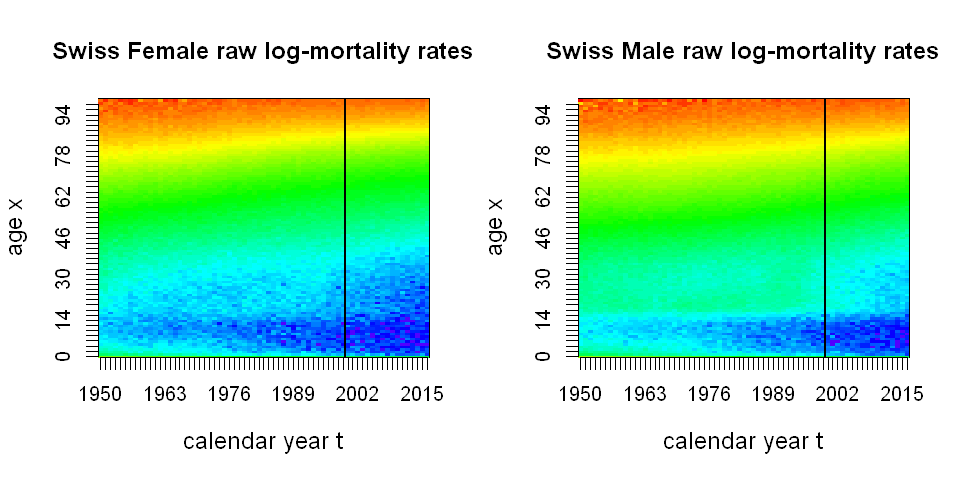

In [3]:
##################################################################
#### Heatmap of selected data
##################################################################

options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))

for (gender in c("Female", "Male")) {
    m0 <- c(min(all_mort$logmx), max(all_mort$logmx))
    # rows are calendar year t, columns are ages x
    logmx <- t(matrix(as.matrix(all_mort[which(all_mort$Gender==gender),"logmx"]), nrow=100, ncol=67))
    image(z=logmx, useRaster=TRUE,  zlim=m0, col=rev(rainbow(n=60, start=0, end=.72)), xaxt='n', yaxt='n', 
          main=list(paste("Swiss ",gender, " raw log-mortality rates", sep=""), cex=1.2), cex.lab=1.2, ylab="age x", 
          xlab="calendar year t")
    axis(1, at=c(0:(2016-1950))/(2016-1950), c(1950:2016))                   
    axis(2, at=c(0:49)/50, labels=c(0:49)*2)                   
    lines(x=rep((1999-1950+0.5)/(2016-1950), 2), y=c(0:1), lwd=2)
}

### 3. Fit the Lee-Carter model to one population <a class="anchor" id="chapter3"></a>

[1] "Female in-sample and out-of-sample loss"
[1] 3.7573 0.6045
[1] "Male in-sample and out-of-sample loss"
[1] 8.8110 1.8152


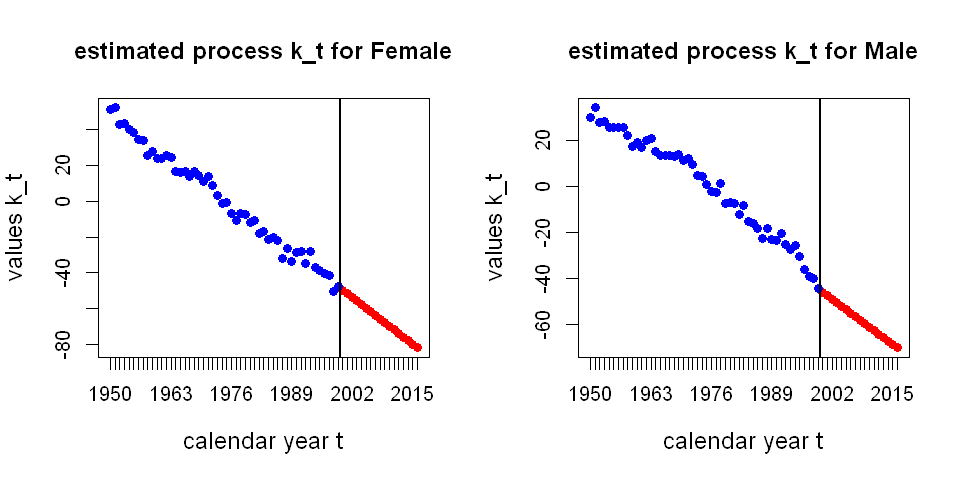

In [4]:
##################################################################
#### Fit Lee Carter to the selected country and extrapolate with Random Walk with Drift
##################################################################

options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))

for (gender in c("Female", "Male")) {
    ObsYear <- 1999
    train <- all_mort[Year<=ObsYear][Gender == gender]
    min(train$Year)

    ### fit via SVD
    train[,ax:= mean(logmx), by = (Age)]
    train[,mx_adj:= logmx-ax]  
    rates_mat <- as.matrix(train %>% dcast.data.table(Age~Year, value.var = "mx_adj", sum))[,-1]
    svd_fit <- svd(rates_mat)

    ax <- train[,unique(ax)]
    bx <- svd_fit$u[,1]*svd_fit$d[1]
    kt <- svd_fit$v[,1]

    c1 <- mean(kt)
    c2 <- sum(bx)
    ax <- ax+c1*bx
    bx <- bx/c2
    kt <- (kt-c1)*c2

    ### extrapolation and forecast
    vali  <- all_mort[Year>ObsYear][Gender == gender]    
    t_forecast <- vali[,unique(Year)] %>% length()
    forecast_kt  =kt %>% forecast::rwf(t_forecast, drift = T)
    kt_forecast = forecast_kt$mean


    ##################################################################
    #### Illustrate and back-test Lee-Carter prediction
    ##################################################################
    
    # illustration selected drift
    plot_data <- c(kt, kt_forecast)
    plot(plot_data, pch=20, col="red", cex=1.5, cex.lab=1.2, xaxt='n', ylab="values k_t", xlab="calendar year t", 
         main=list(paste("estimated process k_t for ",gender, sep=""), cex=1.2)) 
    points(kt, col="blue", pch=20, cex=1.5)
    axis(1, at=c(1:length(plot_data)), labels=c(1:length(plot_data))+1949)                   
    abline(v=(length(kt)+0.5), lwd=2)


    # in-sample and out-of-sample analysis    
    fitted = (ax+(bx)%*%t(kt)) %>% melt
    train$pred_LC_svd = fitted$value %>% exp
    fitted_vali = (ax+(bx)%*%t(kt_forecast)) %>% melt
    vali$pred_LC_svd =   fitted_vali$value %>% exp
    print(paste(gender,  'in-sample and out-of-sample loss'))
    print(round(c((mean((train$mx-train$pred_LC_svd)^2)*10^4) , (mean((vali$mx-vali$pred_LC_svd)^2)*10^4)),4))
}

### 4. Define the different networks considered <a class="anchor" id="chapter4"></a>

In [5]:
##################################################################
### Designing an LSTMs
##################################################################

require(keras)

# single hidden LSTM layer
LSTM1 <- function(T0, tau0, tau1, y0=0, optimizer){
    Input <- layer_input(shape=c(T0,tau0), dtype='float32', name='Input') 
    Output = Input %>%  
       layer_lstm(units=tau1, activation='tanh', recurrent_activation='tanh', name='LSTM1') %>%
       layer_dense(units=1, activation=k_exp, name="Output",
                   weights=list(array(0,dim=c(tau1,1)), array(log(y0),dim=c(1)))) 
    model <- keras_model(inputs = list(Input), outputs = c(Output))
    model %>% compile(loss = 'mean_squared_error', optimizer = optimizer)
     }
     

# double hidden LSTM layers
LSTM2 <- function(T0, tau0, tau1, tau2, y0=0, optimizer){
    Input <- layer_input(shape=c(T0,tau0), dtype='float32', name='Input') 
    Output = Input %>%  
       layer_lstm(units=tau1, activation='tanh', recurrent_activation='tanh', 
                  return_sequences=TRUE, name='LSTM1') %>%
       layer_lstm(units=tau2, activation='tanh', recurrent_activation='tanh', name='LSTM2') %>%           
       layer_dense(units=1, activation=k_exp, name="Output",
                   weights=list(array(0,dim=c(tau2,1)), array(log(y0),dim=c(1))))  
    model <- keras_model(inputs = list(Input), outputs = c(Output))
    model %>% compile(loss = 'mean_squared_error', optimizer = optimizer)
     }


# triple hidden LSTM layers
LSTM3 <- function(T0, tau0, tau1, tau2, tau3, y0=0, optimizer){
    Input <- layer_input(shape=c(T0,tau0), dtype='float32', name='Input') 
    Output = Input %>%  
       layer_lstm(units=tau1, activation='tanh', recurrent_activation='tanh', 
                  return_sequences=TRUE, name='LSTM1') %>%
       layer_lstm(units=tau2, activation='tanh', recurrent_activation='tanh', 
                  return_sequences=TRUE, name='LSTM2') %>%           
       layer_lstm(units=tau3, activation='tanh', recurrent_activation='tanh', name='LSTM3') %>%           
       layer_dense(units=1, activation=k_exp, name="Output",
                   weights=list(array(0,dim=c(tau3,1)), array(log(y0),dim=c(1))))  
    model <- keras_model(inputs = list(Input), outputs = c(Output))
    model %>% compile(loss = 'mean_squared_error', optimizer = optimizer)
     }
     

# time-distributed layer on LSTMs
LSTM_TD <- function(T0, tau0, tau1, y0=0, optimizer){
    Input <- layer_input(shape=c(T0,tau0), dtype='float32', name='Input') 
    Output = Input %>%  
       layer_lstm(units=tau1, activation='tanh', recurrent_activation='tanh', 
                  return_sequences=TRUE, name='LSTM1') %>%
       time_distributed(layer_dense(units=1, activation=k_exp, name="Output"), name='TD') 
    model <- keras_model(inputs = list(Input), outputs = c(Output))
    model %>% compile(loss = 'mean_squared_error', optimizer = optimizer)
     }
     
# single hidden GRU layer
GRU1 <- function(T0, tau0, tau1, y0=0, optimizer){
    Input <- layer_input(shape=c(T0,tau0), dtype='float32', name='Input') 
    Output = Input %>%  
       layer_gru(units=tau1, activation='tanh', recurrent_activation='tanh', name='GRU1') %>%
       layer_dense(units=1, activation=k_exp, name="Output",
                   weights=list(array(0,dim=c(tau1,1)), array(log(y0),dim=c(1)))) 
    model <- keras_model(inputs = list(Input), outputs = c(Output))
    model %>% compile(loss = 'mean_squared_error', optimizer = optimizer)
     }
     

# double hidden GRU layers
GRU2 <- function(T0, tau0, tau1, tau2, y0=0, optimizer){
    Input <- layer_input(shape=c(T0,tau0), dtype='float32', name='Input') 
    Output = Input %>%  
       layer_gru(units=tau1, activation='tanh', recurrent_activation='tanh', 
                  return_sequences=TRUE, name='GRU1') %>%
       layer_gru(units=tau2, activation='tanh', recurrent_activation='tanh', name='GRU2') %>%           
       layer_dense(units=1, activation=k_exp, name="Output",
          weights=list(array(0,dim=c(tau2,1)), array(log(y0),dim=c(1)))) 
    model <- keras_model(inputs = list(Input), outputs = c(Output))
    model %>% compile(loss = 'mean_squared_error', optimizer = optimizer)
     }
     
# triple hidden GRU layers
GRU3 <- function(T0, tau0, tau1, tau2, tau3, y0=0, optimizer){
    Input <- layer_input(shape=c(T0,tau0), dtype='float32', name='Input') 
    Output = Input %>%  
       layer_gru(units=tau1, activation='tanh', recurrent_activation='tanh', 
                  return_sequences=TRUE, name='GRU1') %>%
       layer_gru(units=tau2, activation='tanh', recurrent_activation='tanh', 
                  return_sequences=TRUE, name='GRU2') %>%           
       layer_gru(units=tau3, activation='tanh', recurrent_activation='tanh', name='GRU3') %>%           
       layer_dense(units=1, activation=k_exp, name="Output",
          weights=list(array(0,dim=c(tau3,1)), array(log(y0),dim=c(1)))) 
    model <- keras_model(inputs = list(Input), outputs = c(Output))
    model %>% compile(loss = 'mean_squared_error', optimizer = optimizer)
     }

# triple hidden LSTM layers both genders
LSTM3.Gender <- function(T0, tau0, tau1, tau2, tau3, y0=0, optimizer){
    Input <- layer_input(shape=c(T0,tau0), dtype='float32', name='Input') 
    Gender <- layer_input(shape=c(1), dtype='float32', name='Gender') 
    RNN = Input %>%  
       layer_lstm(units=tau1, activation='tanh', recurrent_activation='tanh', 
                  return_sequences=TRUE, name='LSTM1') %>%
       layer_lstm(units=tau2, activation='tanh', recurrent_activation='tanh', 
                  return_sequences=TRUE, name='LSTM2') %>%           
       layer_lstm(units=tau3, activation='tanh', recurrent_activation='tanh', name='LSTM3')  
       Output = list(RNN, Gender) %>% layer_concatenate(name="Concat")%>%                    
       layer_dense(units=1, activation=k_exp, name="Output",
                   weights=list(array(0,dim=c(tau3+1,1)), array(log(y0),dim=c(1))))  
    model <- keras_model(inputs = list(Input, Gender), outputs = c(Output))
    model %>% compile(loss = 'mean_squared_error', optimizer = optimizer)
     }


# triple hidden GRU layers both gender
GRU3.Gender <- function(T0, tau0, tau1, tau2, tau3, y0=0, optimizer){
    Input <- layer_input(shape=c(T0,tau0), dtype='float32', name='Input') 
    Gender <- layer_input(shape=c(1), dtype='float32', name='Gender') 
    RNN = Input %>%  
       layer_gru(units=tau1, activation='tanh', recurrent_activation='tanh', 
                  return_sequences=TRUE, name='GRU1') %>%
       layer_gru(units=tau2, activation='tanh', recurrent_activation='tanh', 
                  return_sequences=TRUE, name='GRU2') %>%           
       layer_gru(units=tau3, activation='tanh', recurrent_activation='tanh', name='GRU3') 
    Output = list(RNN, Gender) %>% layer_concatenate(name="Concat")%>%           
       layer_dense(units=1, activation=k_exp, name="Output",
          weights=list(array(0,dim=c(tau3+1,1)), array(log(y0),dim=c(1)))) 
    model <- keras_model(inputs = list(Input, Gender), outputs = c(Output))
    model %>% compile(loss = 'mean_squared_error', optimizer = optimizer)
     }


# double hidden FNN layers
FNN <- function(T0, tau0, tau1, tau2, y0=0, optimizer){
    Input <- layer_input(shape=c(T0,tau0), dtype='float32', name='Input')
    Output = Input %>% layer_reshape(target_shape=c(T0*tau0), name='Reshape') %>%
       layer_dense(units=tau1, activation='tanh', name='Layer1') %>%
       layer_dense(units=tau2, activation='tanh', name='Layer2') %>%           
       layer_dense(units=1, activation=k_exp, name="Output",
                   weights=list(array(0,dim=c(tau2,1)), array(log(y0),dim=c(1)))) 
    model <- keras_model(inputs = list(Input), outputs = c(Output))
    model %>% compile(loss = 'mean_squared_error', optimizer = optimizer)
     }

Loading required package: keras
Warning message:
"package 'keras' was built under R version 3.6.3"

### 5. Prepare data for RNNs <a class="anchor" id="chapter5"></a>

In [6]:
##################################################################
### prepare data for Recurrent Neural Networks 
##################################################################

data.preprocessing.RNNs <- function(data.raw, gender, T0, tau0, ObsYear=1999){    
    mort_rates <- data.raw[which(data.raw$Gender==gender), c("Year", "Age", "logmx")] 
    mort_rates <- dcast(mort_rates, Year ~ Age, value.var="logmx")
    # selecting data
    train.rates <- as.matrix(mort_rates[which(mort_rates$Year <= ObsYear),])
    # adding padding at the border
    (delta0 <- (tau0-1)/2)
    if (delta0>0){for (i in 1:delta0){
         train.rates <- as.matrix(cbind(train.rates[,1], train.rates[,2], train.rates[,-1], train.rates[,ncol(train.rates)]))
       }}
   train.rates <- train.rates[,-1]
   (t1 <- nrow(train.rates)-(T0-1)-1)
   (a1 <- ncol(train.rates)-(tau0-1)) 
   (n.train <- t1 * a1) # number of training samples
   xt.train <- array(NA, c(n.train, T0, tau0))
   YT.train <- array(NA, c(n.train))
   for (t0 in (1:t1)){
     for (a0 in (1:a1)){
           xt.train[(t0-1)*a1+a0,,] <- train.rates[t0:(t0+T0-1), a0:(a0+tau0-1)]
           YT.train[(t0-1)*a1+a0] <-   train.rates[t0+T0, a0+delta0]
      }}
   list(xt.train, YT.train)
      }
      
      
##################################################################
### recursive prediction
##################################################################
      
recursive.prediction <- function(ObsYear, all_mort2, gender, T0, tau0, x.min, x.max, model.p){       
   single.years <- array(NA, c(2016-ObsYear))

   for (ObsYear1 in ((ObsYear+1):2016)){
     data2 <- data.preprocessing.RNNs(all_mort2[which(all_mort2$Year >= (ObsYear1-10)),], gender, T0, tau0, ObsYear1)
     # MinMaxScaler (with minimum and maximum from above)
     x.vali <- array(2*(data2[[1]]-x.min)/(x.min-x.max)-1, dim(data2[[1]]))
     y.vali <- -data2[[2]]
     Yhat.vali2 <- exp(-as.vector(model.p %>% predict(x.vali)))
     single.years[ObsYear1-ObsYear] <- round(10^4*mean((Yhat.vali2-exp(-y.vali))^2),4)
     predicted <- all_mort2[which(all_mort2$Year==ObsYear1),]
     keep <- all_mort2[which(all_mort2$Year!=ObsYear1),]
     predicted$logmx <- -as.vector(model %>% predict(x.vali))
     predicted$mx <- exp(predicted$logmx)
     all_mort2 <- rbind(keep,predicted)
     all_mort2 <- all_mort2[order(Gender, Year, Age),]
                       }
     list(all_mort2, single.years)
     }                  


recursive.prediction.Gender <- function(ObsYear, all_mort2, gender, T0, tau0, x.min, x.max, model.p){       
   single.years <- array(NA, c(2016-ObsYear))

   for (ObsYear1 in ((ObsYear+1):2016)){
     data2 <- data.preprocessing.RNNs(all_mort2[which(all_mort2$Year >= (ObsYear1-10)),], gender, T0, tau0, ObsYear1)
     # MinMaxScaler (with minimum and maximum from above)
     x.vali <- array(2*(data2[[1]]-x.min)/(x.min-x.max)-1, dim(data2[[1]]))
     if (gender=="Female"){yy <- 0}else{yy <- 1}
     x.vali <- list(x.vali, rep(yy, dim(x.vali)[1]))
     y.vali <- -data2[[2]]
     Yhat.vali2 <- exp(-as.vector(model.p %>% predict(x.vali)))
     single.years[ObsYear1-ObsYear] <- round(10^4*mean((Yhat.vali2-exp(-y.vali))^2),4)
     predicted <- all_mort2[which(all_mort2$Year==ObsYear1),]
     keep <- all_mort2[which(all_mort2$Year!=ObsYear1),]
     predicted$logmx <- -as.vector(model %>% predict(x.vali))
     predicted$mx <- exp(predicted$logmx)
     all_mort2 <- rbind(keep,predicted)
     all_mort2 <- all_mort2[order(Gender, Year, Age),]
                       }
     list(all_mort2, single.years)
     }                  

##################################################################
### plotting functions
##################################################################

plot.losses <- function(name.model, gender, val_loss, loss){
     plot(val_loss,col="cyan3", pch=20, ylim=c(0,0.1), main=list(paste("early stopping: ",name.model,", ", gender, sep=""), cex=1.2),xlab="epochs", ylab="MSE loss", cex=1.2, cex.lab=1.2)
     lines(loss,col="blue")
     abline(h=0.05, lty=1, col="black")
     legend(x="bottomleft", col=c("blue","cyan3"), lty=c(1,-1), lwd=c(1,-1), pch=c(-1,20), legend=c("in-sample loss", "out-of-sample loss"))
   }   

### 6. Toy Examples Recurrent Neural Nets <a class="anchor" id="chapter6"></a>

In [7]:
options(repr.plot.width=5, repr.plot.height=5)

Model: "model"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
Input (InputLayer)                  [(None, 10, 3)]                 0           
________________________________________________________________________________
LSTM1 (LSTM)                        (None, 5)                       180         
________________________________________________________________________________
Output (Dense)                      (None, 1)                       6           
Total params: 186
Trainable params: 186
Non-trainable params: 0
________________________________________________________________________________
Model: "model_1"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
Input (InputLayer)                  [(None, 10, 3)]                 0           
_____________

[1] 5.893786

Model: "model_6"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
Input (InputLayer)                  [(None, 10, 3)]                 0           
________________________________________________________________________________
LSTM1 (LSTM)                        (None, 10, 5)                   180         
________________________________________________________________________________
LSTM2 (LSTM)                        (None, 4)                       160         
________________________________________________________________________________
Output (Dense)                      (None, 1)                       5           
Total params: 345
Trainable params: 345
Non-trainable params: 0
________________________________________________________________________________


   user  system elapsed 
 121.88    6.68   75.49 

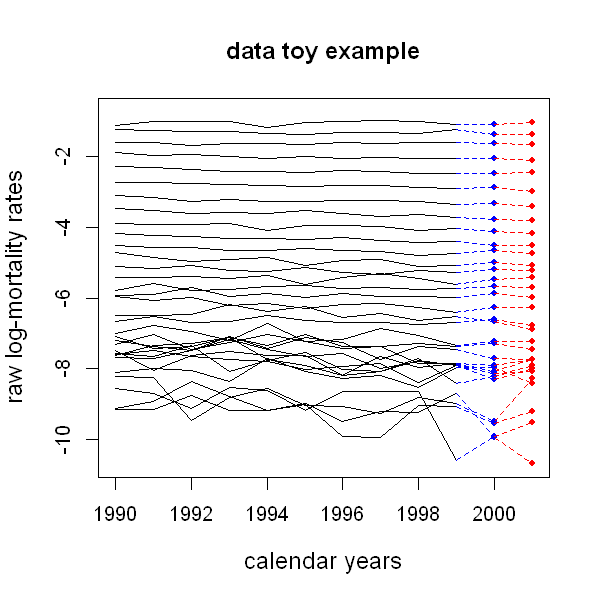

[1] 0.0577 0.0886

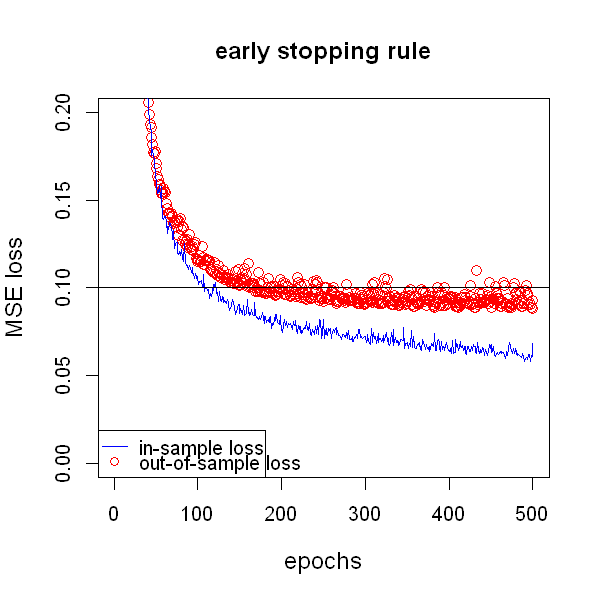

In [8]:
##################################################################
### LSTMs and GRUs
##################################################################

T0 <- 10
tau0 <- 3
tau1 <- 5
tau2 <- 4

summary(LSTM1(T0, tau0, tau1, 0, "nadam"))
summary(LSTM2(T0, tau0, tau1, tau2, 0, "nadam"))
summary(LSTM_TD(T0, tau0, tau1, 0, "nadam"))
summary(GRU1(T0, tau0, tau1, 0, "nadam"))
summary(GRU2(T0, tau0, tau1, tau2, 0, "nadam"))
summary(FNN(T0, tau0, tau1, tau2, 0, "nadam"))

##################################################################
### Bringing the data in the right structure for a toy example
##################################################################

gender <- "Female"
ObsYear <- 2000

mort_rates <- all_mort[which(all_mort$Gender==gender), c("Year", "Age", "logmx")] 
mort_rates <- dcast(mort_rates, Year ~ Age, value.var="logmx")


T0 <- 10     # lookback period
tau0 <- 3    # dimension of x_t (should be odd for our application)
delta0 <- (tau0-1)/2

toy_rates <- as.matrix(mort_rates[which(mort_rates$Year %in% c((ObsYear-T0):(ObsYear+1))),])

xt <- array(NA, c(2,ncol(toy_rates)-tau0, T0, tau0))
YT <- array(NA, c(2,ncol(toy_rates)-tau0))

for (i in 1:2){for (a0 in 1:(ncol(toy_rates)-tau0)){ 
    xt[i,a0,,] <- toy_rates[c(i:(T0+i-1)),c((a0+1):(a0+tau0))]
    YT[i,a0] <- toy_rates[T0+i,a0+1+delta0]
      }}

plot(x=toy_rates[1:T0,1], y=toy_rates[1:T0,2], col="white", xlab="calendar years", ylab="raw log-mortality rates", cex.lab=1.2, cex=1.2, main=list("data toy example", cex=1.2), xlim=range(toy_rates[,1]), ylim=range(toy_rates[,-1]), type='l')
for (a0 in 2:ncol(toy_rates)){
  if (a0 %in% (c(1:100)*3)){
    lines(x=toy_rates[1:T0,1], y=toy_rates[1:T0,a0])    
    points(x=toy_rates[(T0+1):(T0+2),1], y=toy_rates[(T0+1):(T0+2),a0], col=c("blue", "red"), pch=20)
    lines(x=toy_rates[(T0):(T0+1),1], y=toy_rates[(T0):(T0+1),a0], col="blue", lty=2)
    lines(x=toy_rates[(T0+1):(T0+2),1], y=toy_rates[(T0+1):(T0+2),a0], col="red", lty=2)
    }}
    
    
##################################################################
### LSTMs and GRUs
##################################################################

x.train <- array(2*(xt[1,,,]-min(xt))/(max(xt)-min(xt))-1, c(ncol(toy_rates)-tau0, T0, tau0))
x.vali  <- array(2*(xt[2,,,]-min(xt))/(max(xt)-min(xt))-1, c(ncol(toy_rates)-tau0, T0, tau0))
y.train <- - YT[1,]
(y0 <- mean(y.train))
y.vali  <- - YT[2,]

### examples

tau1 <- 5    # dimension of the outputs z_t^(1) first RNN layer
tau2 <- 4    # dimension of the outputs z_t^(2) second RNN layer

CBs <- callback_model_checkpoint("./CallBack/best_model", monitor = "val_loss", verbose = 0,  save_best_only = TRUE, save_weights_only = TRUE)
model <- LSTM2(T0, tau0, tau1, tau2, y0, "nadam")
summary(model)

# takes 40 seconds on my laptop
{t1 <- proc.time()
  fit <- model %>% fit(x=x.train, y=y.train, validation_data=list(x.vali, y.vali),
                                  batch_size=10, epochs=500, verbose=0, callbacks=CBs)
 proc.time()-t1}

plot(fit[[2]]$val_loss,col="red", ylim=c(0,0.2), main=list("early stopping rule", cex=1.2),xlab="epochs", ylab="MSE loss", cex=1.2, cex.lab=1.2)
lines(fit[[2]]$loss,col="blue")
abline(h=0.1, lty=1, col="black")
legend(x="bottomleft", col=c("blue","red"), lty=c(1,-1), lwd=c(1,-1), pch=c(-1,1), legend=c("in-sample loss", "out-of-sample loss"))



load_model_weights_hdf5(model, "./CallBack/best_model")
Yhat.train1 <- as.vector(model %>% predict(x.train))
Yhat.vali1 <- as.vector(model %>% predict(x.vali))
c(round(mean((Yhat.train1-y.train)^2),4), round(mean((Yhat.vali1-y.vali)^2),4))

### 7. Fit recurrent neural network to HMD data for female and male individually <a class="anchor" id="chapter7"></a>

Model: "model_7"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
Input (InputLayer)                  [(None, 10, 5)]                 0           
________________________________________________________________________________
LSTM1 (LSTM)                        (None, 10, 20)                  2080        
________________________________________________________________________________
LSTM2 (LSTM)                        (None, 10, 15)                  2160        
________________________________________________________________________________
LSTM3 (LSTM)                        (None, 10)                      1040        
________________________________________________________________________________
Output (Dense)                      (None, 1)                       11          
Total params: 5,291
Trainable params: 5,291
Non-trainable params: 0
________________________

   user  system elapsed 
 438.55   22.21  164.31 

[1] 2.4631

[1] 0.3647

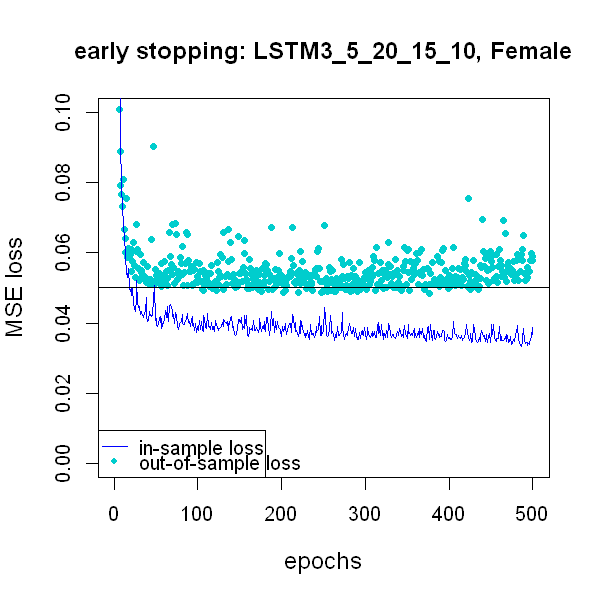

In [9]:
##################################################################
### Setting the parameters and load data
##################################################################

# choice of parameters
T0 <- 10
tau0 <- 5
gender <- "Female"
ObsYear <- 1999

# training data pre-processing 
data1 <- data.preprocessing.RNNs(all_mort, gender, T0, tau0, ObsYear)

# validation data pre-processing
all_mort2 <- all_mort[which((all_mort$Year > (ObsYear-10))&(Gender==gender)),]
all_mortV <- all_mort2
vali.Y <- all_mortV[which(all_mortV$Year > ObsYear),]
 
# MinMaxScaler data pre-processing
x.min <- min(data1[[1]])
x.max <- max(data1[[1]])
x.train <- array(2*(data1[[1]]-x.min)/(x.min-x.max)-1, dim(data1[[1]]))
y.train <- - data1[[2]]
y0 <- mean(y.train)

##################################################################
### LSTM architectures
##################################################################

# network architecture deep 3 network
tau1 <- 20
tau2 <- 15
tau3 <- 10
optimizer <- 'adam'

# choose either LSTM or GRU network
RNN.type <- "LSTM"
#RNN.type <- "GRU"

{if (RNN.type=="LSTM"){model <- LSTM3(T0, tau0, tau1, tau2, tau3, y0, optimizer)}else{model <- GRU3(T0, tau0, tau1, tau2, tau3, y0, optimizer)}
 name.model <- paste(RNN.type,"3_", tau0, "_", tau1, "_", tau2, "_", tau3, sep="")
 file.name <- paste("./CallBack/best_model_", name.model,"_", gender, sep="")
 summary(model)}

# define callback
CBs <- callback_model_checkpoint(file.name, monitor = "val_loss", verbose = 0,  save_best_only = TRUE, save_weights_only = TRUE)

# gradient descent fitting: takes roughly 200 seconds on my laptop
{t1 <- proc.time()
  fit <- model %>% fit(x=x.train, y=y.train, validation_split=0.2,
                                        batch_size=100, epochs=500, verbose=0, callbacks=CBs)                                        
proc.time()-t1}

# plot loss figures
plot.losses(name.model, gender, fit[[2]]$val_loss, fit[[2]]$loss)

# calculating in-sample loss: LC is c(Female=3.7573, Male=8.8110)
load_model_weights_hdf5(model, file.name)
round(10^4*mean((exp(-as.vector(model %>% predict(x.train)))-exp(-y.train))^2),4)

# calculating out-of-sample loss: LC is c(Female=0.6045, Male=1.8152)
pred.result <- recursive.prediction(ObsYear, all_mort2, gender, T0, tau0, x.min, x.max, model)
vali <- pred.result[[1]][which(all_mort2$Year > ObsYear),]
round(10^4*mean((vali$mx-vali.Y$mx)^2),4)



### 8. Fit recurrent neural network to HMD data for both genders <a class="anchor" id="chapter8"></a>

Model: "model_8"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
Input (InputLayer)        [(None, 10, 5)]   0                                   
________________________________________________________________________________
LSTM1 (LSTM)              (None, 10, 20)    2080     Input[0][0]                
________________________________________________________________________________
LSTM2 (LSTM)              (None, 10, 15)    2160     LSTM1[0][0]                
________________________________________________________________________________
LSTM3 (LSTM)              (None, 10)        1040     LSTM2[0][0]                
________________________________________________________________________________
Gender (InputLayer)       [(None, 1)]       0                                   
________________________________________________________________________________
Concat (Con

   user  system elapsed 
 870.88   41.03  314.54 

[1] 4.7463

[1] 0.2751

[1] 1.6267

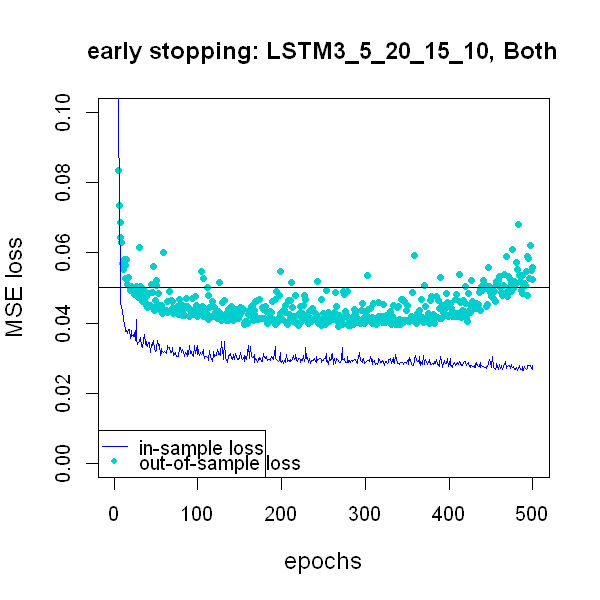

In [10]:
##################################################################
### Setting the parameters and load data
##################################################################

# choice of parameters
T0 <- 10
tau0 <- 5
ObsYear <- 1999

# training data pre-processing 
data1 <- data.preprocessing.RNNs(all_mort, "Female", T0, tau0, ObsYear)
data2 <- data.preprocessing.RNNs(all_mort, "Male", T0, tau0, ObsYear)

xx <- dim(data1[[1]])[1]
x.train <- array(NA, dim=c(2*xx, dim(data1[[1]])[c(2,3)]))
y.train <- array(NA, dim=c(2*xx))
gender.indicator <- rep(c(0,1), xx)
for (l in 1:xx){
   x.train[(l-1)*2+1,,] <- data1[[1]][l,,]
   x.train[(l-1)*2+2,,] <- data2[[1]][l,,]
   y.train[(l-1)*2+1] <- -data1[[2]][l]
   y.train[(l-1)*2+2] <- -data2[[2]][l]
          }
# MinMaxScaler data pre-processing
x.min <- min(x.train)
x.max <- max(x.train)
x.train <- list(array(2*(x.train-x.min)/(x.min-x.max)-1, dim(x.train)), gender.indicator)
y0 <- mean(y.train)



# validation data pre-processing
all_mort2.Female <- all_mort[which((all_mort$Year > (ObsYear-10))&(Gender=="Female")),]
all_mortV.Female <- all_mort2.Female
vali.Y.Female <- all_mortV.Female[which(all_mortV.Female$Year > ObsYear),]
all_mort2.Male <- all_mort[which((all_mort$Year > (ObsYear-10))&(Gender=="Male")),]
all_mortV.Male <- all_mort2.Male
vali.Y.Male <- all_mortV.Male[which(all_mortV.Male$Year > ObsYear),]


##################################################################
### LSTM architectures
##################################################################

# network architecture deep 3 network
tau1 <- 20
tau2 <- 15
tau3 <- 10
optimizer <- 'adam'

# choose either LSTM or GRU network
RNN.type <- "LSTM"
#RNN.type <- "GRU"

{if (RNN.type=="LSTM"){model <- LSTM3.Gender(T0, tau0, tau1, tau2, tau3, y0, optimizer)}else{model <- GRU3.Gender(T0, tau0, tau1, tau2, tau3, y0, optimizer)}
 name.model <- paste(RNN.type,"3_", tau0, "_", tau1, "_", tau2, "_", tau3, sep="")
 #file.name <- paste("./Model_Full_Param/best_model_", name.model, sep="")
 file.name <- paste("./CallBack/best_model_", name.model, sep="")
 summary(model)}

# define callback
CBs <- callback_model_checkpoint(file.name, monitor = "val_loss", verbose = 0,  save_best_only = TRUE, save_weights_only = TRUE)

# gradient descent fitting: takes roughly 400 seconds on my laptop
{t1 <- proc.time()
  fit <- model %>% fit(x=x.train, y=y.train, validation_split=0.2,
                                        batch_size=100, epochs=500, verbose=0, callbacks=CBs)                                        
proc.time()-t1}

# plot loss figures
plot.losses(name.model, "Both", fit[[2]]$val_loss, fit[[2]]$loss)

# calculating in-sample loss: LC is c(Female=3.7573, Male=8.8110)
load_model_weights_hdf5(model, file.name)
round(10^4*mean((exp(-as.vector(model %>% predict(x.train)))-exp(-y.train))^2),4)

# calculating out-of-sample loss: LC is c(Female=0.6045, Male=1.8152)
# Female
pred.result <- recursive.prediction.Gender(ObsYear, all_mort2.Female, "Female", T0, tau0, x.min, x.max, model)
vali <- pred.result[[1]][which(all_mort2.Female$Year > ObsYear),]
round(10^4*mean((vali$mx-vali.Y.Female$mx)^2),4)
# Male
pred.result <- recursive.prediction.Gender(ObsYear, all_mort2.Male, "Male", T0, tau0, x.min, x.max, model)
vali <- pred.result[[1]][which(all_mort2.Male$Year > ObsYear),]
round(10^4*mean((vali$mx-vali.Y.Male$mx)^2),4)